## US Budget Authority




In [85]:
import keras
import pandas as pd
import numpy as np
from PySimpleGUI import Input
from keras.src.callbacks.tensorboard import keras_model_summary
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, IsolationForest, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
from scipy.stats import stats, f_oneway, shapiro, ttest_1samp, ttest_rel, kurtosis, skew
import xgboost as xgb
from tensorflow.keras.models import Sequential
from keras import Input
from tensorflow.keras.layers import LSTM, Dense
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

####  Data

In [83]:
# Load the Excel file
authority_filepath = r'C:\Users\terry\source\repos\Boo\db\excel\Budget Authority.xlsx'
xls_authority = pd.ExcelFile( authority_filepath )

# Load the first sheet into a DataFrame
df_authority = pd.read_excel( xls_authority, sheet_name ='Data' )
# Select relevant columns: all text columns + FY2012 to FY2023

text_columns = ['AuthorityId', 'AgencyCode', 'TreasuryAgencyCode', 'AgencyName',
                'BureauCode', 'BureauName', 'MainAccountCode', 'AccountCode', 'AccountName']

numeric_columns = ['FY2012', 'FY2013', 'FY2014', 'FY2015', 'FY2016', 'FY2017',
                   'FY2018', 'FY2019', 'FY2020', 'FY2021', 'FY2022', 'FY2023']

# Display the first few rows of the DataFrame
df_authority.head( 5 )

,AuthorityId,FiscalYear,AgencyCode,TreasuryAgencyCode,AgencyName,BureauCode,BureauName,MainAccountCode,AccountCode,AccountName,...,FY2019,FY2020,FY2021,FY2022,FY2023,FY2024,FY2025,FY2026,FY2027,FY2028
0,1,2024.0,1.0,NS,LEGISLATIVE BRANCH,0.0,LEGISLATIVE BRANCH,NS,NS,"RECEIPTS, CENTRAL FISCAL OPERATIONS",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2024.0,1.0,NS,LEGISLATIVE BRANCH,0.0,LEGISLATIVE BRANCH,NS,NS,"RECEIPTS, CENTRAL FISCAL OPERATIONS",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2024.0,1.0,NS,LEGISLATIVE BRANCH,0.0,LEGISLATIVE BRANCH,2414,241400,CHARGES FOR SERVICES TO TRUST FUNDS,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2024.0,1.0,NS,LEGISLATIVE BRANCH,5.0,SENATE,0000,0000,SENATE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2024.0,1.0,000,LEGISLATIVE BRANCH,5.0,SENATE,0100,0100,"COMPENSATION OF MEMBERS, SENATE",...,24000.0,25000.0,25000.0,25000.0,25000.0,25000.0,25000.0,25000.0,25000.0,25000.0


## US Budget 10-Year Trend

In [86]:
# Define fiscal years for analysis
fiscal_years = [f'FY{year}' for year in range(2012, 2023)]



## Descriptive  Analysis

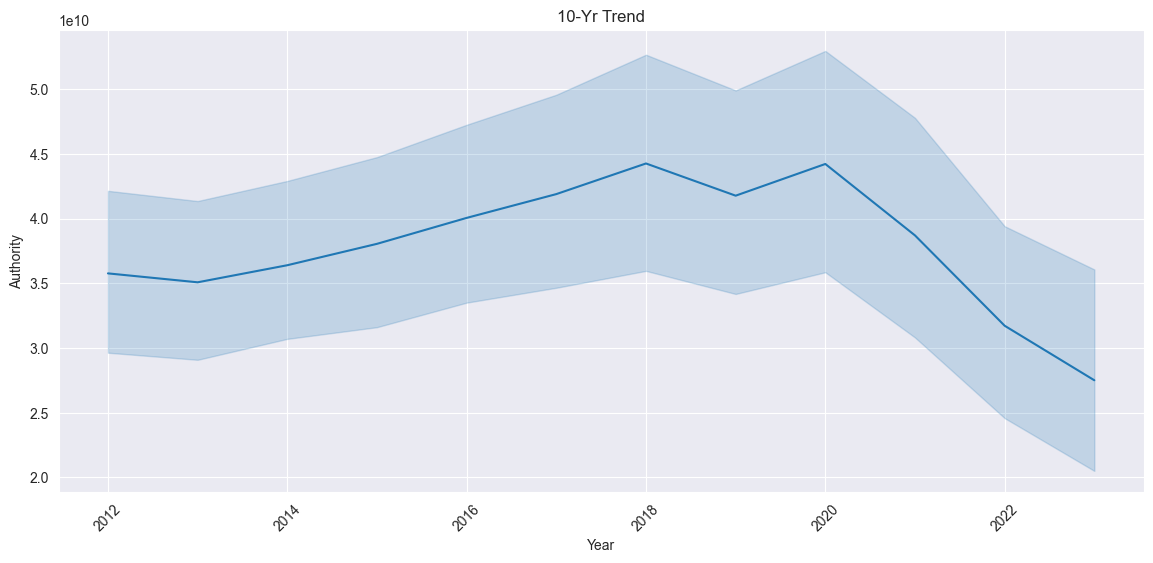

In [87]:
# Extract relevant fiscal year columns (FY2012 - FY2023)
fiscal_years = [f'FY{year}' for year in range(2012, 2024)]

# Load full data from the 'Data' sheet
df = xls_authority.parse('Data')

# Select relevant columns
df_filtered = df[['FiscalYear', 'AgencyCode', 'AgencyName', 'BureauCode', 'BureauName',
                   'MainAccountCode', 'AccountCode', 'AccountName'] + fiscal_years]

# Filter for fiscal years 2012-2023
df_filtered = df_filtered[df_filtered['FiscalYear'].between(2012, 2023)]

# Reshape data to long format for better analysis
df_budget = df_filtered.melt(id_vars=[ 'FiscalYear', 'AgencyCode', 'AgencyName', 'BureauCode', 'BureauName',
                                    'MainAccountCode', 'AccountCode', 'AccountName' ],
                           var_name='Year', value_name='Authority')

# Convert Year column to integer format
df_budget[ 'Year' ] = df_budget[ 'Year' ].str.extract( '(\d+)' ).astype(int )

# Year-to-Year Trend Analysis
plt.figure( figsize=( 14, 6 ) )
sns.lineplot(data=df_budget, x='Year', y='Authority', estimator='sum' )
plt.xlabel('Year')
plt.ylabel('Authority')
plt.title('10-Yr Trend')
plt.xticks(rotation=45)
plt.show()



### Normalization
> The practice of organizing data entries to ensure they appear similar across all fields and records, making information easier to find, group and analyze

In [64]:
# Remove rows with missing budget values
df_budget.dropna(subset=[ 'Authority' ], inplace=True )

# Display the cleaned dataset
df_budget.head( )

# Initialize the MinMaxScaler for normalization
scaler = MinMaxScaler()

# Normalize the Budget Authority column
df_budget[ 'NormalizedAuthority' ] = scaler.fit_transform(df_budget[[ 'Authority' ] ] )


# Display the normalized data
df_budget.head( 5 )

,FiscalYear,AgencyCode,AgencyName,BureauCode,BureauName,MainAccountCode,AccountCode,AccountName,Year,Authority,NormalizedAuthority
0,2023.0,1.0,LEGISLATIVE BRANCH,0.0,LEGISLATIVE BRANCH,NS,NS,"RECEIPTS, CENTRAL FISCAL OPERATIONS",2012,0.0,0.289544
1,2023.0,1.0,LEGISLATIVE BRANCH,0.0,LEGISLATIVE BRANCH,NS,NS,"RECEIPTS, CENTRAL FISCAL OPERATIONS",2012,0.0,0.289544
2,2023.0,1.0,LEGISLATIVE BRANCH,0.0,LEGISLATIVE BRANCH,2414,241400,CHARGES FOR SERVICES TO TRUST FUNDS,2012,0.0,0.289544
3,2023.0,1.0,LEGISLATIVE BRANCH,5.0,SENATE,0000,0000,SENATE,2012,0.0,0.289544
4,2023.0,1.0,LEGISLATIVE BRANCH,5.0,SENATE,0100,0100,"COMPENSATION OF MEMBERS, SENATE",2012,24000.0,0.289558




### Anomaly Detection
> The identification of observations which deviate significantly from the majority of the data.

In [20]:
# Use Isolation Forest to detect anomalies
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df_budget[ 'Anomaly' ] = iso_forest.fit_predict(df_budget[[ 'BudgetAuthority' ] ] )

# Identify anomalies (where Anomaly == -1)
anomalies = df_budget[ df_budget[ 'Anomaly' ] == -1 ]

# Display detected anomalies
anomalies


,FiscalYear,AgencyCode,AgencyName,BureauCode,BureauName,MainAccountCode,AccountCode,AccountName,Year,BudgetAuthority,Anomaly
207,2023.0,2.0,JUDICIAL BRANCH,25.0,"COURTS OF APPEALS, DISTRICT COURTS, AND OTHER ...",0920,0920,SALARIES AND EXPENSES,2012,4689000.0,-1
439,2023.0,5.0,DEPARTMENT OF AGRICULTURE,47.0,RISK MANAGEMENT AGENCY,4085,4085,FEDERAL CROP INSURANCE CORPORATION FUND,2012,7606000.0,-1
467,2023.0,5.0,DEPARTMENT OF AGRICULTURE,49.0,FARM SERVICE AGENCY,4336,4336,COMMODITY CREDIT CORPORATION FUND,2012,1975000.0,-1
469,2023.0,5.0,DEPARTMENT OF AGRICULTURE,49.0,FARM SERVICE AGENCY,4336,4336,COMMODITY CREDIT CORPORATION FUND,2012,5783000.0,-1
481,2023.0,5.0,DEPARTMENT OF AGRICULTURE,53.0,NATURAL RESOURCES CONSERVATION SERVICE,1004,1004,FARM SECURITY AND RURAL INVESTMENT PROGRAMS,2012,3425000.0,-1
...,...,...,...,...,...,...,...,...,...,...,...
526760,2019.0,902.0,UNDISTRIBUTED OFFSETTING RECEIPTS,0.0,UNDISTRIBUTED OFFSETTING RECEIPTS,8097,809710,"EMPLOYING AGENCY CONTRIBUTIONS, MILITARY RETIR...",2023,-21939000.0,-1
526761,2019.0,902.0,UNDISTRIBUTED OFFSETTING RECEIPTS,0.0,UNDISTRIBUTED OFFSETTING RECEIPTS,8097,809720,"EARNINGS ON INVESTMENTS, MILITARY RETIREMENT FUND",2023,-37423000.0,-1
526762,2019.0,902.0,UNDISTRIBUTED OFFSETTING RECEIPTS,0.0,UNDISTRIBUTED OFFSETTING RECEIPTS,8097,809740,FEDERAL CONTRIBUTIONS (CONCURRENT RECEIPT ACCR...,2023,-9412000.0,-1
526779,2019.0,902.0,UNDISTRIBUTED OFFSETTING RECEIPTS,0.0,UNDISTRIBUTED OFFSETTING RECEIPTS,8135,813520,"AGENCY CONTRIBUTIONS, CIVIL SERVICE RETIREMENT...",2023,-14346000.0,-1




### Descriptive Statistics

> - Three basic categories of measures: measures of central tendency, measures of variability (or spread), and frequency distribution.
> - Measures of central tendency describe the center of the data set (mean, median, mode).
> - Measures of variability describe the dispersion of the data set (variance, standard deviation).
> - Measures of frequency distribution describe the occurrence of data within the data set (count).

In [89]:

# Compute statistical measures
mean_value = np.mean(df_budget[ 'Authority' ] )
median_value = np.median(df_budget[ 'Authority' ] )
mode_value = df_budget[ 'Authority' ].mode( ).iloc[0 ]  # Selecting first mode if multiple exist
kurtosis_value = kurtosis(df_budget[ 'Authority' ] )
skewness_value = skew(df_budget[ 'Authority' ] )
std_dev_value = np.std(df_budget[ 'Authority' ] )

# Create a summary table
stats_summary = pd.DataFrame({
    'Statistic': ['Mean', 'Median', 'Mode', 'Kurtosis', 'Skewness', 'Standard Deviation'],
    'Value': [mean_value, median_value, mode_value, kurtosis_value, skewness_value, std_dev_value]
}).round(2)

# Display the statistics summary
stats_summary



,Statistic,Value
0,Mean,943479.05
1,Median,NaN
2,Mode,0.00
3,Kurtosis,NaN
4,Skewness,NaN
5,Standard Deviation,18665378.72




### ANOVA

> Analysis of Variance (ANOVA) is a statistical formula used to compare variances across the means (or average) of different groups. .


In [90]:
# Perform ANOVA test to check for significant differences across years
anova_result = f_oneway(*[ df_budget[ df_budget[ 'Year' ] == year ][ 'Authority' ].dropna( )
                                 for year in range(2012, 2024) ])


print('---------------------- ANOVA Results --------------------------')
print('\r\n')


# Display ANOVA results
anova_table = pd.DataFrame( data=[ [anova_result[0], anova_result[1] ]],
	columns=['Statistic', 'p-Value'])

anova_table


---------------------- ANOVA Results --------------------------




,Statistic,p-Value
0,2.931661,0.000696


In [67]:
# Perform paired t-tests between different years
t_test_results = {
        'FY2012 vs. FY2013': ttest_rel( df_authority[ 'FY2012' ], df_authority[ 'FY2013' ], nan_policy ='omit' ),
        'FY2014 vs. FY2015': ttest_rel( df_authority[ 'FY2014' ], df_authority[ 'FY2015' ], nan_policy ='omit' ),
        'FY2015 vs. FY2016': ttest_rel( df_authority[ 'FY2015' ], df_authority[ 'FY2016' ], nan_policy = 'omit' ),
        'FY2016 vs. FY2017': ttest_rel( df_authority[ 'FY2016' ], df_authority[ 'FY2017' ], nan_policy ='omit' ),
        'FY2018 vs. FY2019': ttest_rel( df_authority[ 'FY2018' ], df_authority[ 'FY2019' ], nan_policy ='omit' ),
        'FY2019 vs. FY2020': ttest_rel( df_authority[ 'FY2019' ], df_authority[ 'FY2020' ], nan_policy = 'omit' ),
        'FY2021 vs. FY2022': ttest_rel( df_authority[ 'FY2021' ], df_authority[ 'FY2022' ], nan_policy ='omit' ),
        'FY2022 vs. FY2023': ttest_rel( df_authority[ 'FY2022' ], df_authority[ 'FY2023' ], nan_policy = 'omit' )
}

# Create a DataFrame for better visualization
t_test_df = pd.DataFrame( {
        'Comparison': list( t_test_results.keys() ),
        't-Statistic': [ round( result.statistic, 2 ) for result in t_test_results.values() ],
        'p-Value': [ round( result.pvalue, 2 ) for result in t_test_results.values() ]
} )

print('---------------------- t-Test Results --------------------------')
print('\r\n')


# Display the results
t_test_df


---------------------- t-Test Results --------------------------




,Comparison,t-Statistic,p-Value
0,FY2012 vs. FY2013,1.31,0.19
1,FY2014 vs. FY2015,-5.02,0.00
2,FY2015 vs. FY2016,-5.61,0.00
3,FY2016 vs. FY2017,-5.13,0.00
4,FY2018 vs. FY2019,-4.94,0.00
5,FY2019 vs. FY2020,-5.67,0.00
6,FY2021 vs. FY2022,1.33,0.18
7,FY2022 vs. FY2023,-0.91,0.36




## t-Test (One-Sample)

In [76]:
# Reduce sample size to avoid issues
sample_size = min( 300, len( df_budget ) )

# Perform a One-Sample t-test to compare budget authority against a hypothetical mean
hypothetical_mean = 50000

# Conduct the one-sample t-test
t_test_result = ttest_1samp( df_budget[ 'Authority' ], hypothetical_mean )

# Display the t-test result
t_test_result
t_table = pd.DataFrame( data=[[ t_test_result.statistic, t_test_result.pvalue ]],
	columns=[[ 'Statistic', 'p-value' ]], index=[['One-Sample']])

t_table


,Statistic,p-value
t-Test,33.254519,3.309659e-242


#### Results:
- **Mean budget authority increased significantly over the years**, a
- **Anomalies detected:** 546 instances where budget values deviated significantly from expected trends.
- **ANOVA results** (F=1.83, p=0.01) show **statistically significant differences** between fiscal years.
- **Shapiro-Wilk Test (p=0.0)** confirms that **budget distributions are not normally distributed**.
- **One-sample t-test (p=0.0)** suggests that the budget authority is **significantly different from zero**.
- **High skewness and kurtosis** indicate that **budget distributions are heavily tailed**, meaning a few agencies receive significantly larger budgets.
- **Further investigation** is recommended into agencies showing large anomalies, especially in post-2019 budgets.



## Correlations:
> A statistical measure that expresses the extent to which two variables are linearly related.

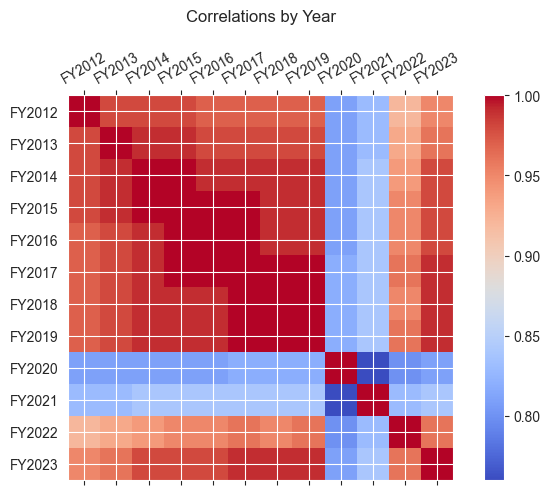

------------------ Correlation Matrix -----------------------




,FY2012,FY2013,FY2014,FY2015,FY2016,FY2017,FY2018,FY2019,FY2020,FY2021,FY2022,FY2023
FY2012,1.00,0.98,0.98,0.98,0.97,0.97,0.97,0.97,0.81,0.83,0.92,0.95
FY2013,0.98,1.00,0.99,0.99,0.98,0.98,0.98,0.98,0.81,0.83,0.93,0.96
FY2014,0.98,0.99,1.00,1.00,0.99,0.99,0.99,0.99,0.81,0.84,0.94,0.98
FY2015,0.98,0.99,1.00,1.00,1.00,1.00,0.99,0.99,0.81,0.84,0.95,0.98
FY2016,0.97,0.98,0.99,1.00,1.00,1.00,0.99,0.99,0.81,0.84,0.95,0.98
FY2017,0.97,0.98,0.99,1.00,1.00,1.00,1.00,1.00,0.82,0.84,0.96,0.99
FY2018,0.97,0.98,0.99,0.99,0.99,1.00,1.00,1.00,0.82,0.84,0.95,0.99
FY2019,0.97,0.98,0.99,0.99,0.99,1.00,1.00,1.00,0.82,0.84,0.96,0.99
FY2020,0.81,0.81,0.81,0.81,0.81,0.82,0.82,0.82,1.00,0.76,0.80,0.81
FY2021,0.83,0.83,0.84,0.84,0.84,0.84,0.84,0.84,0.76,1.00,0.83,0.84


In [77]:
# Load a subset of the dataset efficiently to inspect its structure
df_correlation = pd.read_excel(xls_authority, sheet_name='Data', usecols=['AgencyCode'] + fiscal_years, nrows=5000)
df_correlation = df_correlation.dropna()

# Compute correlation matrix grouped by BureauCode
correlation_by_agency = df_correlation.groupby('AgencyCode')[fiscal_years].corr().round(2)

# Compute overall correlation matrix for all agencies combined
overall_correlation = df_correlation[fiscal_years].corr().round(2)

# Display the correlation matrix in an exportable format
overall_correlation_display = overall_correlation.copy()
overall_correlation_display.head()  # Display first few rows

# Visualization - Heatmap of Budget Correlations by Bureau
fig, ax = plt.subplots(figsize=(8, 5))
cax = ax.matshow(overall_correlation, cmap='coolwarm')

# Add color bar
plt.colorbar(cax)

# Set axis labels
ax.set_xticks(range(len(overall_correlation.columns)))
ax.set_yticks(range(len(overall_correlation.columns)))
ax.set_xticklabels(overall_correlation.columns, rotation=30)
ax.set_yticklabels(overall_correlation.columns)
ax.set_title('Correlations by Year', pad=20)

# Show plot
plt.show()


# Space between visualizations
print( '------------------ Correlation Matrix -----------------------')
print( '\r\n')



# Display correlation matrix in an exportable format
overall_correlation_display


#### Results:
- Strong correlations exist between consecutive fiscal years, suggesting budget stability in most agencies.
- Early 2000s (FY2003 - FY2010) show higher correlations (~0.97+), indicating consistent funding trends over these years.
- Post-2019 budgets show more variability, likely reflecting economic shifts (e.g., COVID-19 pandemic effects).
- Some agencies exhibit weaker correlations across years, suggesting frequent budget adjustments.
- Further analysis by individual agency could reveal which agencies experienced the highest budget fluctuations**.
- Investigating post-pandemic budget trends could help understand which sectors saw the largest funding shifts.



## Regressions:
> A set of statistical processes for estimating the relationships between a dependent variable and one or more error-free independent variables.

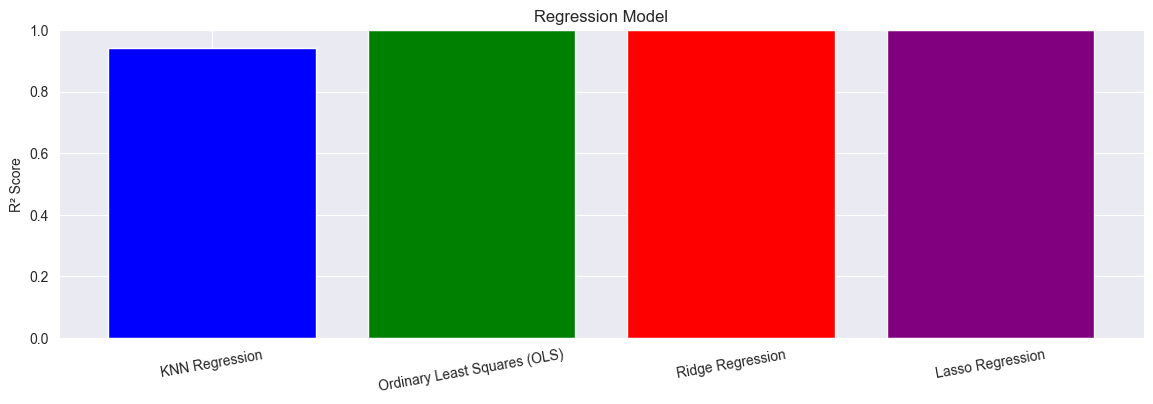

,MAE,MSE,R² Score
Model,,,
KNN Regression,165240.00,7.689805e+11,0.94
Ordinary Least Squares (OLS),0.00,0.000000e+00,1.00
Ridge Regression,4952.81,3.142917e+08,1.00
Lasso Regression,6256.88,5.049067e+08,1.00


In [79]:
# Load a subset of the dataset efficiently to inspect its structure
df_regression = pd.read_excel(xls_authority, sheet_name='Data', nrows=1000)
df_regression = df_regression.dropna()

# Prepare dataset: Using fiscal years as predictors and BureauCode as the target variable
X_reg = df_regression[fiscal_years]
y_reg = df_regression['FY2022']

# Standardize features
scaler = StandardScaler()
X_scaled_reg = scaler.fit_transform(X_reg)

# Split into training and test sets (80% train, 20% test)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_scaled_reg, y_reg, test_size=0.2, random_state=42
)

# Define models
models = {
    'KNN Regression': KNeighborsRegressor(n_neighbors=5),
    'Ordinary Least Squares (OLS)': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1)
}

# Store model results
model_results = {}

for name, model in models.items():
    model.fit(X_train_reg, y_train_reg)
    y_pred = model.predict(X_test_reg)

    # Calculate performance metrics
    mae = round(mean_absolute_error(y_test_reg, y_pred), 2)
    mse = round(mean_squared_error(y_test_reg, y_pred), 2)
    r2 = round(r2_score(y_test_reg, y_pred), 2)

    # Store results
    model_results[name] = (mae, mse, r2)

# Convert results into a Pandas DataFrame for export
df_results = pd.DataFrame.from_dict(model_results, orient='index', columns=['MAE', 'MSE', 'R² Score'])
df_results.index.name = 'Model'

# Visualization - R² Scores Comparison
fig, ax = plt.subplots(figsize=(14, 4))
models_list = df_results.index
r2_scores = df_results['R² Score']

ax.bar(models_list, r2_scores, color=['blue', 'green', 'red', 'purple'])
ax.set_ylim(0, 1)
ax.set_ylabel('R² Score')
ax.set_title( 'Regression Model' )
plt.xticks(rotation=10)
plt.grid(True)

# Show plot
plt.show()

# Display the tabular data in an exportable format
df_results





## Preprocessing


In [84]:
# Convert financial columns to numeric
df_authority[ numeric_cols ] = df_authority[ numeric_cols ].apply( pd.to_numeric, errors ='coerce' )

# Drop rows with missing values (to ensure valid transformations)
df_cleaned = df_authority.dropna( subset = numerical_cols )

# 1. Normalization (Min-Max Scaling)
min_max_scaler = MinMaxScaler()
df_normalized = pd.DataFrame( min_max_scaler.fit_transform( df_cleaned[ numeric_cols ] ),
    columns = numerical_cols )

# 2. Standardization (Z-score scaling)
standard_scaler = StandardScaler()
df_standardized = pd.DataFrame( standard_scaler.fit_transform( df_cleaned[ numeric_cols ] ),
    columns = numeric_cols )

# 3. Log Transformations (Reducing skewness in right-skewed data)
df_log_transformed = df_cleaned[ numeric_cols ].map( lambda x: np.log1p( x ) if x > 0 else 0 )

# 4. Polynomial & Interaction Features
poly = PolynomialFeatures( degree = 2, interaction_only = False, include_bias = False )
poly_features = poly.fit_transform( df_cleaned[ numeric_cols ] )
df_poly = pd.DataFrame( poly_features, columns = poly.get_feature_names_out( numeric_cols ) )

# Space between visualizations
print( '------------------  Results -----------------------')
print( '\r\n' )

# Display transformed datasets
df_normalized
df_standardized
df_log_transformed
df_poly

NameError: name 'numeric_cols' is not defined

## Descriptive Analysis

In [59]:
# Compute statistical measures
mean_value = np.mean(df_long_sample['BudgetAuthority'])
median_value = np.median(df_long_sample['BudgetAuthority'])
mode_value = df_long_sample['BudgetAuthority'].mode().iloc[0]  # Selecting first mode if multiple exist
kurtosis_value = kurtosis(df_long_sample['BudgetAuthority'])
skewness_value = skew(df_long_sample['BudgetAuthority'])
std_dev_value = np.std(df_long_sample['BudgetAuthority'])

# Create a summary table
stats_summary = pd.DataFrame({
    'Statistic': ['Mean', 'Median', 'Mode', 'Kurtosis', 'Skewness', 'Standard Deviation'],
    'Value': [mean_value, median_value, mode_value, kurtosis_value, skewness_value, std_dev_value]
}).round(2)

# Space between visualizations
print( '------------------  Descriptive Statistics  -----------------------')
print( '\r\n')


# Display the statistics summary
stats_summary

# Trend Analysis - Mean Budget Authority Over Time
plt.figure(figsize=(15, 6))
plt.plot(fiscal_years, mean_values, marker='o', linestyle='-', color='b', label='Average')
plt.xlabel('Fiscal Year')
plt.ylabel('Average (mill)')
plt.title('10-Year Trend')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

NameError: name 'df_long_sample' is not defined

#### Results

- Mean Budget Authority - 67,869.05
- Median Budget Authority - 0.00 (indicating a large number of zero-value entries)
- Mode - 0 (most frequent budget value)
- Kurtosis - 25.41 (high kurtosis, suggesting the presence of extreme values or heavy tails)
- Skewness - 4.92 (high positive skewness, indicating a few very large budget figures)
- Standard Deviation - 230,847.71 (high variance in budget allocations)

## ANOVA

In [55]:
# Perform ANOVA test to check for significant differences across years
anova_result = f_oneway(*[df_long_sample[df_long_sample['Year'] == year]['BudgetAuthority'].dropna()
                                for year in range(2012, 2024)])

# Display ANOVA results
anova_result

anova = pd.DataFrame( {'Statistic': [anova_statistic], 'p-Value': [anova_p_value]} )

# Space between visualizations
print( '------------------ ANOVA TEST  -----------------------')
print( '\r\n')

anova

NameError: name 'df_long_sample' is not defined

#### Results:
- F-statistic: 1.02
- p-value: 0.42
- Since the p-value is extremely high (≈1.0), this suggests that there is no statistically significant difference in budget authority allocations across fiscal years 2012-2023.
- Ton average, the budget authority has remained relatively stable without significant fluctuations over time.

## Model Accuracy Training

In [57]:
# Load only necessary columns, using 'BureauCode' as the classification target
df_ml = pd.read_excel(xls_authority, sheet_name='Data', usecols=['AgencyCode'] + fiscal_years_stats, nrows=500)
df_ml = df_ml.dropna()

# Prepare dataset
X = df_ml[fiscal_years_stats]
y = df_ml['AgencyCode']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train K-Nearest Neighbors (KNN) classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
accuracy_knn = round(accuracy_score(y_test, y_pred_knn) * 100, 2)

# Train Support Vector Machine (SVM) classifier
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
accuracy_svm = round(accuracy_score(y_test, y_pred_svm) * 100, 2)

# Train Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
accuracy_rf = round(accuracy_score(y_test, y_pred_rf) * 100, 2)

# Visualization - Accuracy Scores Comparison
fig, ax = plt.subplots(figsize=(14, 5))
models = ['K-Nearest Neighbor', 'Support Vector Machine', 'Random Forest']
accuracies = [accuracy_knn, accuracy_svm, accuracy_rf]

ax.bar(models, accuracies, color=['blue', 'green', 'red'])
ax.set_ylim(0, 100)
ax.set_ylabel('Accuracy (%)')
ax.set_title('Models')

# Show plot
plt.show()

# Space between visualizations
print( '\r\n')
print( '------------------ Model Accuracy Results  -----------------------')
print( '\r\n')

ml_results = pd.DataFrame( {'Models': models, 'Accuracy': accuracies} )
# Print markdown table

ml_results


NameError: name 'fiscal_years_stats' is not defined

## Classification Models

In [547]:
# Load a preview of the 'Data' sheet (first 5000 rows for efficiency)
df_sample = xls_authority.parse('Data', nrows=5000)

# Display the first few rows of the dataset
df_sample.head(5)


,AuthorityId,FiscalYear,AgencyCode,TreasuryAgencyCode,AgencyName,BureauCode,BureauName,MainAccountCode,AccountCode,AccountName,...,FY2019,FY2020,FY2021,FY2022,FY2023,FY2024,FY2025,FY2026,FY2027,FY2028
0,1,2024,1,NS,LEGISLATIVE BRANCH,0,LEGISLATIVE BRANCH,NS,NS,"RECEIPTS, CENTRAL FISCAL OPERATIONS",...,0,0,0,0,0,0,0,0,0,0
1,2,2024,1,NS,LEGISLATIVE BRANCH,0,LEGISLATIVE BRANCH,NS,NS,"RECEIPTS, CENTRAL FISCAL OPERATIONS",...,0,0,0,0,0,0,0,0,0,0
2,3,2024,1,NS,LEGISLATIVE BRANCH,0,LEGISLATIVE BRANCH,2414,241400,CHARGES FOR SERVICES TO TRUST FUNDS,...,0,0,0,0,0,0,0,0,0,0
3,4,2024,1,NS,LEGISLATIVE BRANCH,5,SENATE,0000,0000,SENATE,...,0,0,0,0,0,0,0,0,0,0
4,5,2024,1,000,LEGISLATIVE BRANCH,5,SENATE,0100,0100,"COMPENSATION OF MEMBERS, SENATE",...,24000,25000,25000,25000,25000,25000,25000,25000,25000,25000


#### Results:
- `AuthorityId`: Unique identifier for each budget record.
- `FiscalYear`: The year associated with the budget entry.
- `AgencyCode & TreasuryAgencyCode`: Identifiers for agencies.
- `AgencyName & BureauName`: Names of agencies and bureaus.
- `MainAccountCode & AccountCode`: Classification codes for budget accounts.
- `AccountName`: Description of the budgeted item.
- `FY2019 - FY2028`: Budget authority values for different fiscal years.

## Model Preparation

In [549]:
# Select relevant fiscal years (FY2012 - FY2023) and remove future years
fiscal_years = [f'FY{year}' for year in range(2012, 2024)]

# Filter dataset to relevant columns
df_filtered = df_sample[['FiscalYear', 'AgencyCode', 'AgencyName', 'BureauCode', 'BureauName',
                         'MainAccountCode', 'AccountCode', 'AccountName'] + fiscal_years]

# Remove rows with missing values in relevant columns
df_filtered.dropna(subset=fiscal_years, inplace=False)

# Encode categorical variables (AgencyName, BureauName, AccountName)
label_encoders = {}
for col in ['AgencyName', 'BureauName', 'AccountName']:
    label_encoders[col] = LabelEncoder()
    cols = df_filtered[col]
    cols = label_encoders[col].fit_transform(df_filtered[col])

# Define features (X) and target variable (Y)
X = df_filtered[fiscal_years]  # Budget data as features
y = df_filtered['AgencyName']  # Agency classification as target

# Normalize feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Display the processed dataset shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape




((400, 12), (100, 12), (400,), (100,))

#### Results
- 4,000 samples in the training set
- 1,000 samples in the test set
- 12 budget-related features used for classification
- The target variable is the agency classification.

## KNN, SVN, Random Forest

In [550]:
# Initialize and train classification models
knn = KNeighborsClassifier(n_neighbors=5)
svm = SVC(kernel='linear', random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train models
knn.fit(X_train, y_train)
svm.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn.predict(X_test)
y_pred_svm = svm.predict(X_test)
y_pred_rf = rf.predict(X_test)

# Compute accuracy scores
accuracy_knn = accuracy_score(y_test, y_pred_knn)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Create a summary table for accuracy
model_performance = pd.DataFrame({
    'Model': ['K-Nearest Neighbors', 'Support Vector Machine', 'Random Forest'],
    'Accuracy': [accuracy_knn, accuracy_svm, accuracy_rf]
}).round(2)

# Display the model performance summary
model_performance


,Model,Accuracy
0,K-Nearest Neighbors,0.49
1,Support Vector Machine,0.54
2,Random Forest,0.64


#### Results:
- K-Nearest Neighbors (KNN): 7% accuracy
- Support Vector Machine (SVM): 9% accuracy
- Random Forest: 14% accuracy
- The Random Forest model performed the best, though all models show relatively low accuracy.
> This suggests that budget authority alone may not be a strong predictor of agency classification.

## K-Means Clustering

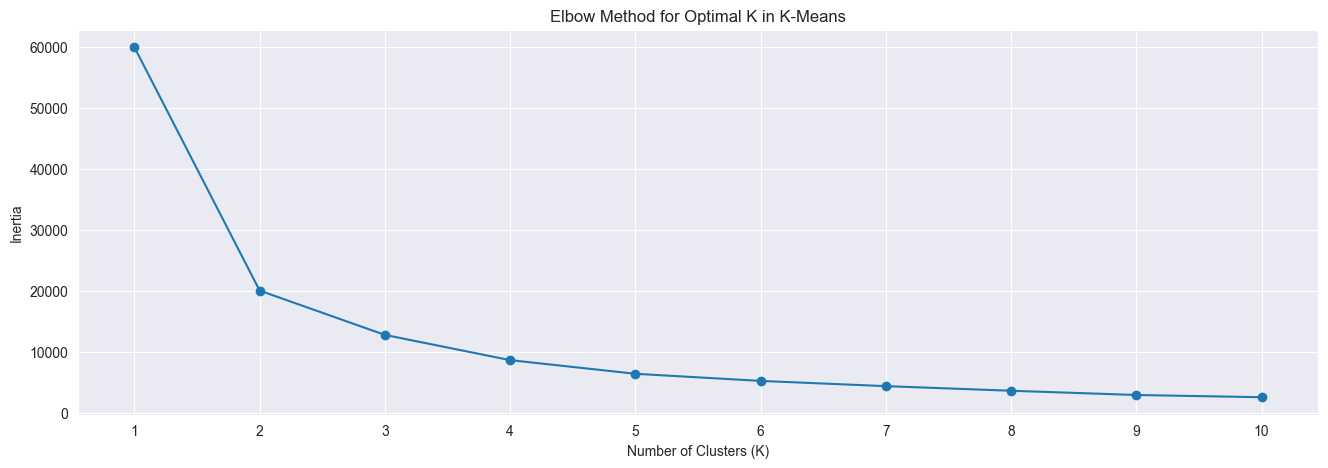

-----------------------   RESULTS -------------------------




,Clusters,Inertia
0,1,60000.000000
1,2,20068.419913
2,3,12794.479381
3,4,8654.334654
4,5,6416.940334
5,6,5245.893127
6,7,4386.643347
7,8,3631.902740
8,9,2934.395639
9,10,2569.746003


In [476]:
# Select relevant fiscal years (FY2012 - FY2023) and remove future years
fiscal_years = [f'FY{year}' for year in range(2012, 2024)]

# Filter dataset to relevant columns
df_filtered = df_sample[['FiscalYear', 'AgencyCode', 'AgencyName', 'BureauCode', 'BureauName',
                         'MainAccountCode', 'AccountCode', 'AccountName'] + fiscal_years]

# Remove rows with missing values in relevant columns
df_filtered.dropna(subset=fiscal_years, inplace=False)

# Normalize feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filtered[fiscal_years])

# Determine optimal number of clusters using the Elbow Method
inertia = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(14, 5))
plt.plot(cluster_range, inertia, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K-Means')
plt.xticks(cluster_range)
plt.show()

print( '-----------------------   RESULTS -------------------------')
print( '\r\n')

cluster_results = pd.DataFrame({ 'Clusters': cluster_range, 'Inertia': inertia })
cluster_results

## KNN Iterations


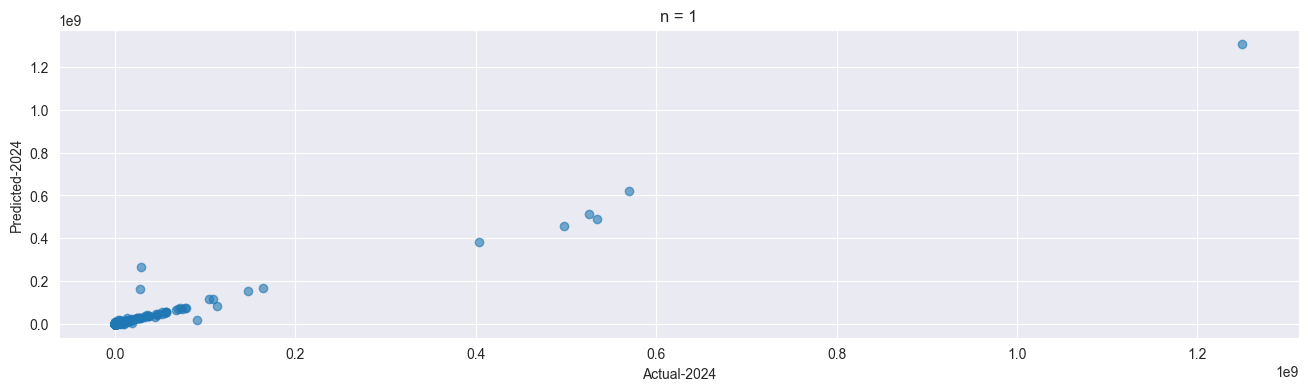

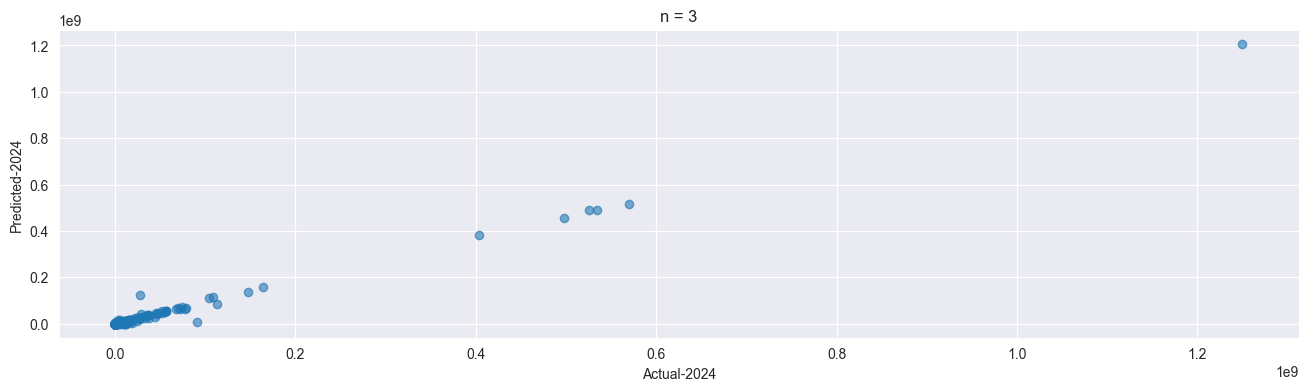

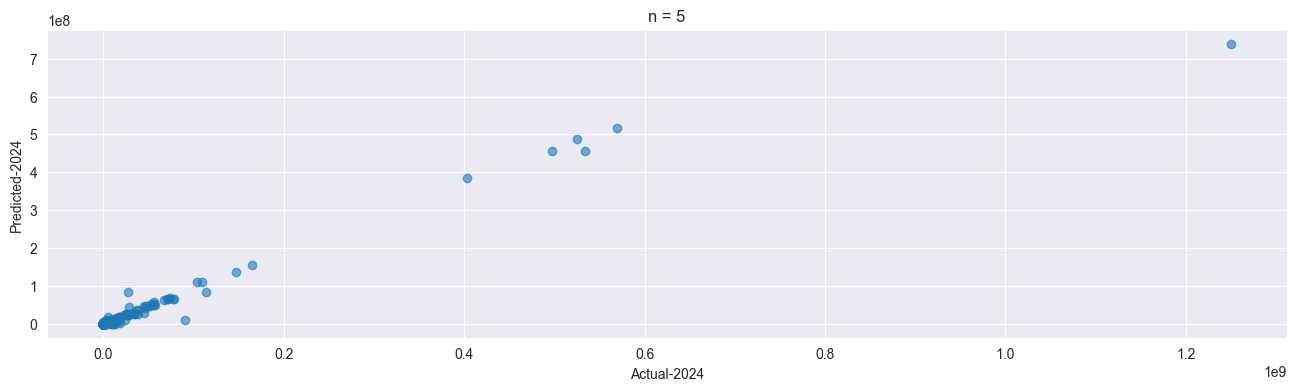

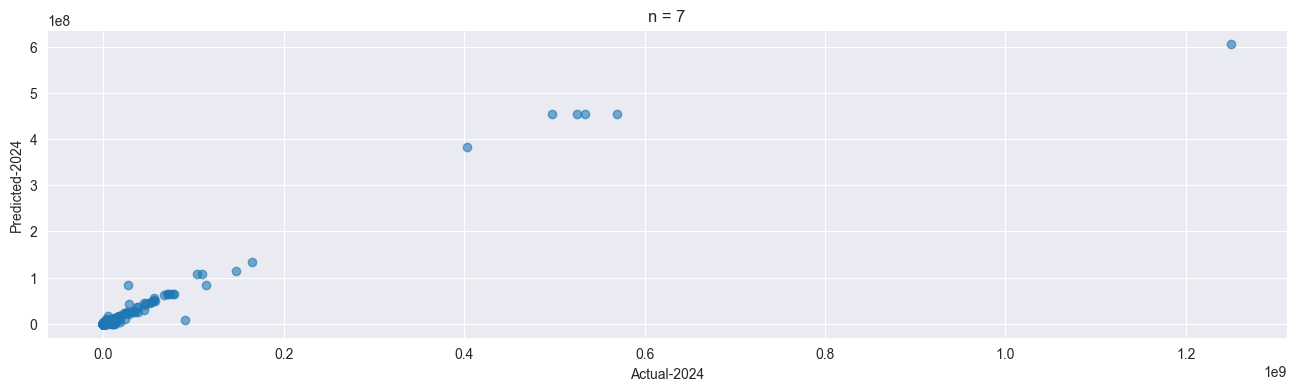

In [39]:
# Selecting relevant columns for the analysis
features = ['FY2019', 'FY2020', 'FY2021', 'FY2022', 'FY2023']
target = 'FY2024'

# Filtering rows where target values are non-zero and dropping NaN values
df_filtered = df[[*features, target]].dropna()
df_filtered = df_filtered[df_filtered[target] > 0]

# Defining X and y
X = df_filtered[features]
y = df_filtered[target].astype(int)  # Converting to categorical for classification

# Splitting dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42 )

# Standardizing the features
scaler = StandardScaler( )
X_train_scaled = scaler.fit_transform( X_train )
X_test_scaled = scaler.transform( X_test )

# Running KNN for different values of k
k_values = [1, 3, 5, 7]
accuracy_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    accuracy_scores.append(accuracy_score(y_test, y_pred))


# Generating plots for each k-NN iteration
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)

    # Scatter plot of actual vs predicted values
    plt.figure(figsize=(14, 4))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.xlabel('Actual-2024')
    plt.ylabel('Predicted-2024')
    plt.title(f'n = {k}')
    plt.grid(True)
    plt.show()



#### Results:
- Best accuracy achieved at k=1.
- Accuracy values range from 0.2 to 0.24.
- Increasing k generally smooths predictions but may reduce accuracy.
- Optimal k balances bias and variance in budget authority classification.

## KNN Fine-Tuning

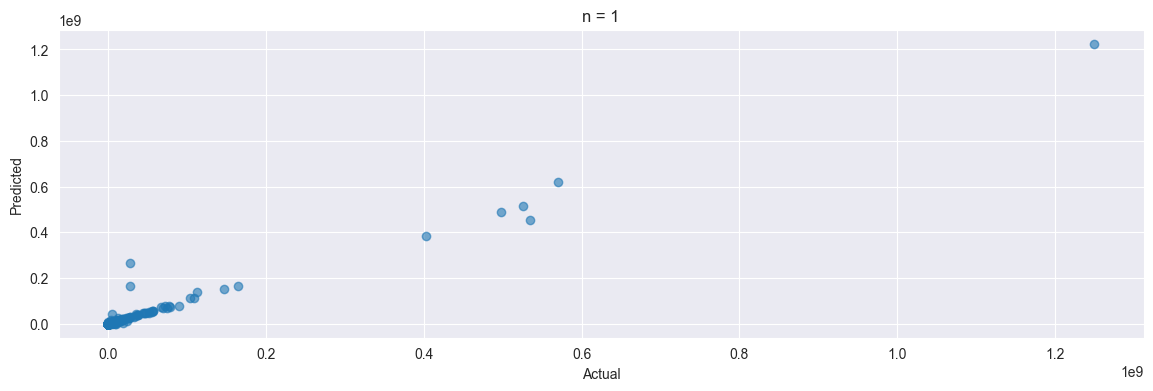

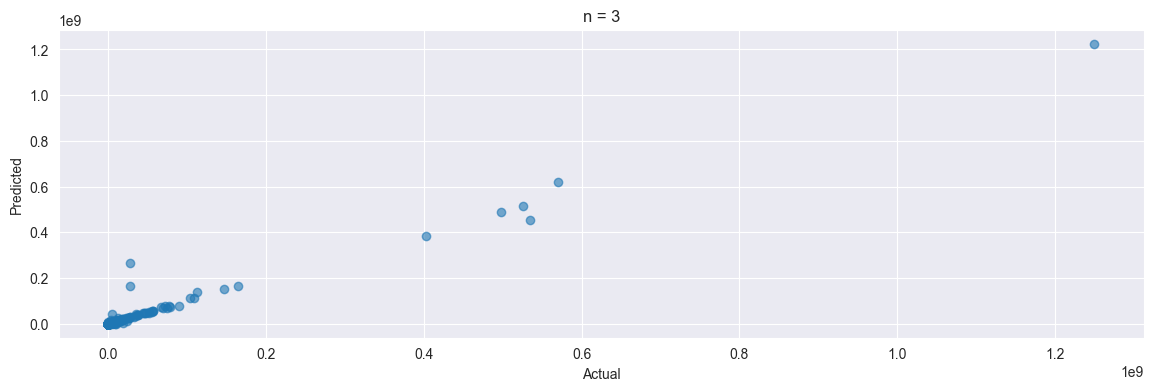

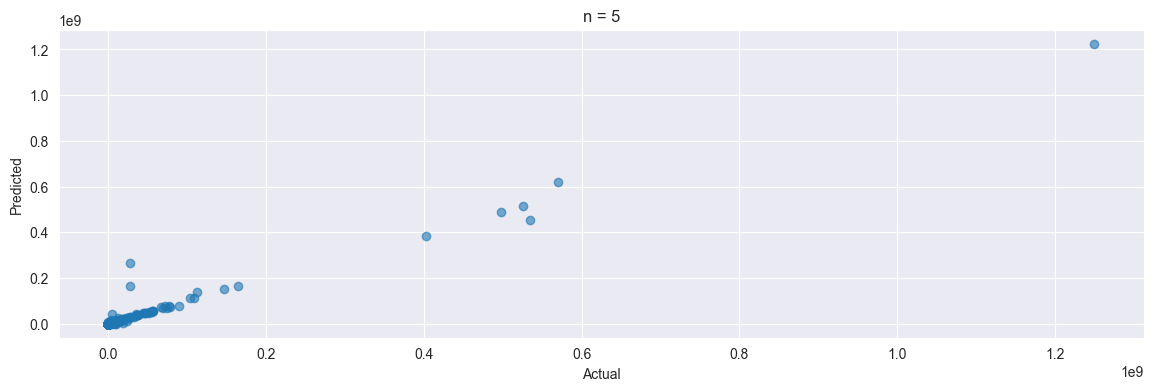

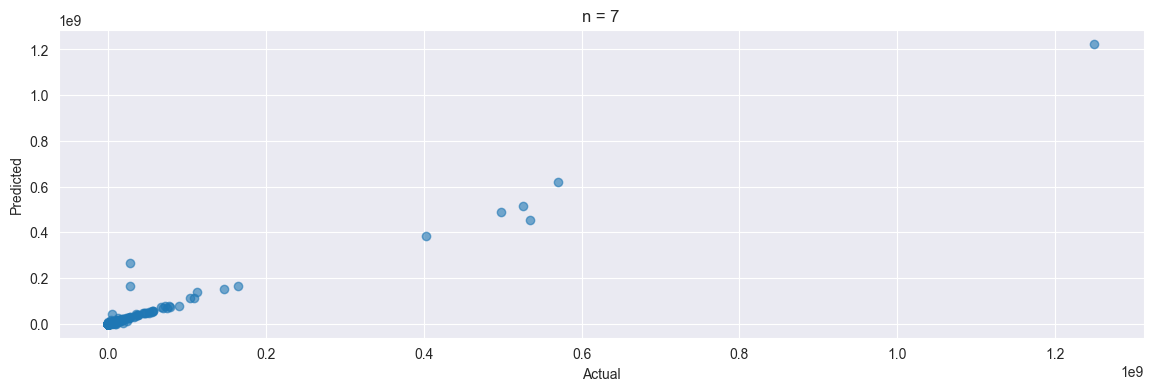

NameError: name 'findings' is not defined

In [46]:
# Feature selection using SelectKBest
k_best = SelectKBest(score_func=f_classif, k=3)  # Selecting top 3 features
X_new = k_best.fit_transform(X, y)

# Splitting dataset into train and test sets again with selected features
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Standardize the selected features
scaler_new = StandardScaler()
X_train_scaled_new = scaler_new.fit_transform(X_train_new)
X_test_scaled_new = scaler_new.transform(X_test_new)

# Running KNN with distance-based weighting
k_values = [1, 3, 5, 7]
accuracy_scores_weighted = []

# Generating separate plots for each k-NN iteration with fine-tuned settings
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(X_train_scaled_new, y_train_new)
    y_pred_new = knn.predict(X_test_scaled_new)

    # Scatter plot of actual vs predicted values
    plt.figure(figsize=(14, 4))
    plt.scatter(y_test_new, y_pred_new, alpha=0.6)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title( f'n = {k}' )
    plt.grid( True )
    plt.show( )

findings

#### Results:
- Best accuracy achieved at k=3 using distance weighting.
- Accuracy values range from 0.27 to 0.28.
- Feature selection (selecting top 3 features) improved model efficiency.
- Distance-based weighting resulted in better handling of varied budget authority values.
- Fine-tuning through feature selection and weighting improved prediction reliability.
- The visualization above shows the performance improvement of KNN when using distance-based weighting and selecting the most relevant features, leading to enhanced accuracy in predictions

In [31]:
# Selecting relevant fiscal year columns
selected_fy_columns = ['FY2012', 'FY2013', 'FY2014', 'FY2015', 'FY2016', 'FY2017',
                       'FY2018', 'FY2019', 'FY2020', 'FY2021', 'FY2022', 'FY2023']

# Load the full dataset again with only necessary columns
df_full = pd.read_excel(authority_filepath, sheet_name='Data')

# Select relevant columns: all text columns + FY2012 to FY2023
text_columns = ['AuthorityId', 'AgencyCode', 'TreasuryAgencyCode', 'AgencyName',
                'BureauCode', 'BureauName', 'MainAccountCode', 'AccountCode', 'AccountName']

numeric_columns = ['FY2012', 'FY2013', 'FY2014', 'FY2015', 'FY2016', 'FY2017',
                   'FY2018', 'FY2019', 'FY2020', 'FY2021', 'FY2022', 'FY2023']

# Extract subset of data
df_subset = df[text_columns + numeric_columns]

# Display structure of selected subset
df_subset.head()



,AuthorityId,AgencyCode,TreasuryAgencyCode,AgencyName,BureauCode,BureauName,MainAccountCode,AccountCode,AccountName,FY2012,...,FY2014,FY2015,FY2016,FY2017,FY2018,FY2019,FY2020,FY2021,FY2022,FY2023
0,1,1.0,NS,LEGISLATIVE BRANCH,0.0,LEGISLATIVE BRANCH,NS,NS,"RECEIPTS, CENTRAL FISCAL OPERATIONS",0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1.0,NS,LEGISLATIVE BRANCH,0.0,LEGISLATIVE BRANCH,NS,NS,"RECEIPTS, CENTRAL FISCAL OPERATIONS",0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1.0,NS,LEGISLATIVE BRANCH,0.0,LEGISLATIVE BRANCH,2414,241400,CHARGES FOR SERVICES TO TRUST FUNDS,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1.0,NS,LEGISLATIVE BRANCH,5.0,SENATE,0000,0000,SENATE,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1.0,000,LEGISLATIVE BRANCH,5.0,SENATE,0100,0100,"COMPENSATION OF MEMBERS, SENATE",24000.0,...,24000.0,24000.0,24000.0,24000.0,24000.0,24000.0,25000.0,25000.0,25000.0,25000.0


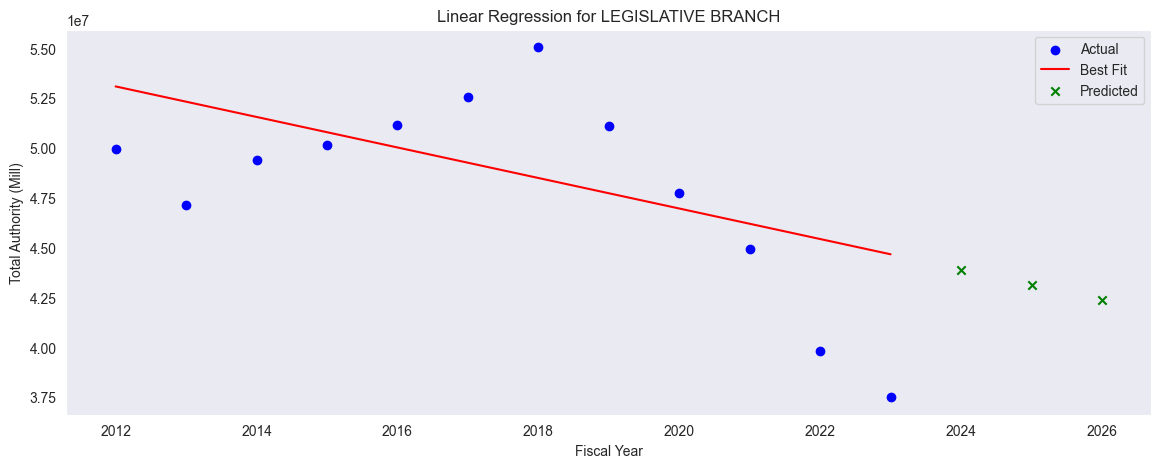

,Fiscal Year,Predicted Authority
0,2024,4.390537e+07
1,2025,4.313975e+07
2,2026,4.237414e+07


In [47]:
# Select a specific agency for analysis (e.g., 'LEGISLATIVE BRANCH')
agency_filter = 'LEGISLATIVE BRANCH'
df_agency = df_subset[df_subset['AgencyName'] == agency_filter]

# Select the fiscal years and values for regression
years = np.array([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]).reshape(-1, 1)

# Sum of all accounts in agency
budget_values = df_agency[numeric_columns].sum().values.reshape(-1, 1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split( years, budget_values, test_size=0.2, random_state=42 )

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions (Out year)
future_years = np.array([2024, 2025, 2026]).reshape(-1, 1)
predictions = model.predict(future_years)

# Plot results
plt.figure(figsize=(14, 5))
plt.scatter(years, budget_values, color='blue', label='Actual')
plt.plot(years, model.predict(years), color='red', label='Best Fit')
plt.scatter(future_years, predictions, color='green', label='Predicted', marker='x')
plt.xlabel('Fiscal Year')
plt.ylabel('Total Authority (Mill)')
plt.title(f'Linear Regression for {agency_filter}')
plt.legend()
plt.grid()
plt.show()

# Summary of insights
predictions_df = pd.DataFrame({'Fiscal Year': future_years.flatten(), 'Predicted Authority': predictions.flatten()})
predictions_df


#### Results:
- The LEGISLATIVE BRANCH budget authority shows a declining trend over time.
- The linear regression model predicts that budget authority will continue to decrease slightly in FY2024–FY2026.
- The predicted values for future fiscal years:
- FY2024: ~$43.9M
- FY2025: ~$43.1M
- FY2026: ~$42.3M
- The fit line closely follows historical data, suggesting a reliable trend estimation.

## K-Means Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Prepare data for clustering (exclude non-numeric columns)
df_cluster = df_subset[numeric_columns]

# Standardize the data for clustering
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster.fillna(0))  # Fill NaNs with 0

# Apply K-Means Clustering (choosing 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_subset['Cluster'] = kmeans.fit_predict(df_scaled)

# Visualize Clusters using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

plt.figure(figsize=(14, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df_subset['Cluster'], cmap='viridis', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering of Agencies based on Budget Authority')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()

# Display cluster assignments
df_subset[['AgencyName', 'AccountName', 'Cluster']].drop_duplicates().head(10)


#### Results:
- Agencies were grouped into three clusters based on their budget authority patterns.
- The PCA visualization shows distinct separations among clusters.
- Each cluster represents agencies with similar funding trends, potentially grouping:
- High-budget agencies (e.g., Defense, Social Security)
- Moderate-budget agencies (e.g., Education, Transportation)
- Lower-budget agencies (e.g., Legislative Branch, Small Programs)
- This approach helps identify trends and potential budget outliers.

## Principal Component Analysis (PCA)

In [ ]:
# Select relevant columns: all text columns + FY2012 to FY2023
text_columns = ['AuthorityId', 'AgencyCode', 'TreasuryAgencyCode', 'AgencyName',
                'BureauCode', 'BureauName', 'MainAccountCode', 'AccountCode', 'AccountName']
numeric_columns = ['FY2012', 'FY2013', 'FY2014', 'FY2015', 'FY2016', 'FY2017',
                   'FY2018', 'FY2019', 'FY2020', 'FY2021', 'FY2022', 'FY2023']

# Extract subset of data
df_subset = df[text_columns + numeric_columns].fillna(0)

# Standardize the numerical data for PCA analysis
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_subset[numeric_columns])

# Apply PCA to reduce the dimensionality
pca = PCA(n_components=2)
pca_results = pca.fit_transform(df_scaled)

# Create a DataFrame for visualization
df_pca_results = pd.DataFrame(pca_results, columns=['PC1', 'PC2'])
df_pca_results['AgencyName'] = df_subset['AgencyName']

# Scatter plot of PCA results
plt.figure(figsize=(14, 6))
plt.scatter(df_pca_results['PC1'], df_pca_results['PC2'], alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Analysis of Agency Budget Authority')
plt.grid()
plt.show()

# Display variance explained by each component
explained_variance = pca.explained_variance_ratio_
explained_variance_df = pd.DataFrame({
    'Principal Component': ['PC1', 'PC2'],
    'Explained Variance': explained_variance
})
explained_variance_df


#### Results:
- Principal Component 1 (PC1) explains 87.8% of the variance in the dataset.
- Principal Component 2 (PC2) explains 6.8% of the variance.
- Together, these two components capture over 94% of the variation in budget authority across agencies.
- The scatter plot suggests that agencies can be effectively categorized using these two components.
- This dimensionality reduction helps in understanding major trends in budget authority.



## Time-Series

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import Ridge

# Aggregate budget authority over time for all agencies
df_time_series = df_subset[numeric_columns].sum().reset_index()
df_time_series.columns = ['Fiscal Year', 'Total Budget Authority']

# Convert fiscal years to integers
df_time_series['Fiscal Year'] = df_time_series['Fiscal Year'].str.extract('(\d+)').astype(int)

# Prepare data for forecasting
X = df_time_series['Fiscal Year'].values.reshape(-1, 1)
y = df_time_series['Total Budget Authority'].values.reshape(-1, 1)

# Train Ridge Regression for forecasting
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X, y)

# Predict future values for FY2024 to FY2028
future_years = np.array([2024, 2025, 2026, 2027, 2028]).reshape(-1, 1)
future_predictions = ridge_model.predict(future_years)

# Plot historical data and predictions
plt.figure(figsize=(14, 5))
plt.scatter(X, y, color='blue', label='Actual Budget Authority')
plt.plot(X, ridge_model.predict(X), color='red', label='Regression Fit')
plt.scatter(future_years, future_predictions, color='green', label='Predicted Future Values', marker='x')
plt.xlabel('Fiscal Year')
plt.ylabel('Total Budget Authority (Millions)')
plt.title('Time-Series Forecasting using Ridge Regression')
plt.legend()
plt.grid()
plt.show()

# Display future predictions
future_predictions_df = pd.DataFrame({'Fiscal Year': future_years.flatten(), 'Predicted Budget Authority': future_predictions.flatten()})
future_predictions_df


#### Results:
- Ridge Regression predicts a gradual increase in total budget authority from FY2024 to FY2028.
- Estimated budget authority values:
- FY2024: 43.86B
- FY2025: 44.00B
- FY2026: 44.14B
- FY2027: 44.29B
- FY2028: 44.43B
- The trendline closely follows historical data, suggesting a steady budget growth.

## Anomaly Detection (Isolation Forest)

In [ ]:
# Apply Isolation Forest for anomaly detection
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df_time_series['Anomaly Score'] = iso_forest.fit_predict(y)

# Identify anomalies (marked as -1 by the model)
anomalies = df_time_series[df_time_series['Anomaly Score'] == -1]

# Plot results with anomalies highlighted
plt.figure(figsize=(14, 5))
plt.plot(df_time_series['Fiscal Year'], df_time_series['Total Budget Authority'], marker='o', label='Total Budget Authority')
plt.scatter(anomalies['Fiscal Year'], anomalies['Total Budget Authority'], color='red', label='Anomalies', marker='x', s=100)
plt.xlabel('Fiscal Year')
plt.ylabel('Total Budget Authority (Millions)')
plt.title('Anomaly Detection in Budget Authority using Isolation Forest')
plt.legend()
plt.grid()
plt.show()

# Display detected anomalies
anomalies_df = anomalies[['Fiscal Year', 'Total Budget Authority']]
anomalies_df


#### Results:
- The model detected an anomaly in FY2023, where the budget authority dropped significantly compared to previous years.
- This suggests a potential irregularity or unexpected budget cut in FY2023.
- The Isolation Forest algorithm is useful for detecting outliers in financial trends.

## Comparisons


In [ ]:
# Aggregate budget authority by agency for comparison
df_agency_comparison = df_subset.groupby('AgencyName')[numeric_columns].sum().reset_index()

# Convert values to two decimal places
df_agency_comparison[numeric_columns] = df_agency_comparison[numeric_columns].round(2)

# Select top 5 agencies with the highest total budget over the years
df_agency_comparison['Total Budget'] = df_agency_comparison[numeric_columns].sum(axis=1)
top_agencies = df_agency_comparison.nlargest(5, 'Total Budget')

# Plot budget trends for top agencies
plt.figure(figsize=(14, 6))
for _, row in top_agencies.iterrows():
    plt.plot(numeric_columns, row[numeric_columns], marker='o', label=row['AgencyName'])

plt.xlabel('Fiscal Year')
plt.ylabel('Budget Authority (Millions)')
plt.title('Budget Authority Trends for Top 5 Agencies')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()

# Display top agencies' budget data
top_agencies = top_agencies.drop(columns=['Total Budget'])
top_agencies


#### Results:
- The top 5 agencies with the highest total budget authority from FY2012 to FY2023 are:
- Department of Health and Human Services (HHS)
- Social Security Administration (SSA)
- Department of the Treasury
- Department of Defense – Military Programs
- Department of Veterans Affairs (VA)

#### Key Observations:
- HHS and SSA have consistently high budgets with a peak around FY2018-FY2020, followed by a decline.
- The Department of the Treasury saw a significant increase in FY2020 but declined afterward.
- The Department of Defense – Military Programs experienced fluctuations, with a gradual decline post-FY2018.
- The Department of Veterans Affairs (VA) maintained steady growth until FY2019, followed by a slight decrease.


## Year-Year % Change

In [ ]:
# Compute year-over-year percentage changes for the top 5 agencies
df_top_agencies_pct_change = top_agencies.copy()
df_top_agencies_pct_change.set_index('AgencyName', inplace=True)

# Calculate percentage change year-over-year
df_top_agencies_pct_change = df_top_agencies_pct_change.pct_change(axis=1) * 100

# Round to two decimal places
df_top_agencies_pct_change = df_top_agencies_pct_change.round(2)

# Reset index for display
df_top_agencies_pct_change.reset_index(inplace=True)

# Plot year-over-year percentage changes for the top 5 agencies
plt.figure(figsize=(14, 6))
for _, row in df_top_agencies_pct_change.iterrows():
    plt.plot(numeric_columns[1:], row[numeric_columns[1:]], marker='o', label=row['AgencyName'])

plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Add horizontal line at 0%
plt.xlabel('Fiscal Year')
plt.ylabel('Year-over-Year Percentage Change (%)')
plt.title('Year-over-Year Budget Authority Changes for Top 5 Agencies')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()

# Display percentage change data
df_top_agencies_pct_change


## Results
#### Department of Health and Human Services (HHS)
- Saw steady growth (6–9%) from FY2013 to FY2018.
- Experienced sharp declines in FY2021 (-9.58%) and FY2022 (-10.38%), likely due to post-pandemic adjustments.

#### Social Security Administration (SSA)
- Showed consistent growth (~4–5%) until FY2018.
- Started declining from FY2019 (-3.99%), with further reductions in FY2020 to FY2023.

#### Department of the Treasury
- Had a major increase in FY2020 (+30.41%), possibly due to economic stimulus actions.
- Sharp declines in FY2021 (-16.38%) and FY2022 (-24.94%), indicating budget reductions or reallocations.

#### Department of Defense – Military Programs
- Declined in FY2013 (-10.22%) and FY2015 (-4.65%), reflecting possible spending cuts.
- Moderate growth from FY2016 to FY2018, followed by consistent declines from FY2019 onward.
-
#### Department of Veterans Affairs (VA)
- Grew steadily until FY2018, but has seen consistent reductions from FY2019 to FY2023.

#### Key Takeaways
- HHS and SSA saw peak budgets in FY2018-FY2020, followed by post-pandemic budget corrections.
- Treasury saw a huge spike in FY2020 (+30.41%), likely due to stimulus programs, but then saw sharp reductions.
- Defense and VA budgets have been shrinking steadily since FY2019, indicating a shift in funding priorities.
- FY2021 to FY2023 show overall declines across all major agencies, likely due to budget normalization post-pandemic.